In [129]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import auc, roc_curve, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [130]:
country_code=pd.read_csv("C:/Users/chenl/Data Science prep/data/IpAddress_to_Country - Identifying Fraudulent Activities.csv")
data=pd.read_csv("C:/Users/chenl/Data Science prep/data/Fraud_Data - Identifying Fraudulent Activities.csv",parse_dates=["signup_time","purchase_time"])
country_code["lower_bound_ip_address"]=country_code["lower_bound_ip_address"].astype("int64")

In [131]:
# country_code.dtypes
# len(data)
# len(country_code)
# country_code
data["user_id"].nunique()
# users are unique

151112

In [132]:
# look country for each user
def find_country(ip_address):
    temp=country_code[
    (country_code["lower_bound_ip_address"]<=ip_address) &
    (country_code["upper_bound_ip_address"]>=ip_address)
    ]
    if not temp.empty:
        return temp["country"].iloc[0]
    else:
        return "NA"
data["country"]=data["ip_address"].apply(find_country)
data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States


In [133]:
data.info()
# no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
 11  country         151112 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 13.8+ MB


# data preprocessing


feature engineering - hypothesis: 

1. time diff from sign up and purchase
2. check if multi account used same IP address, create a binary column T/F
3. check if multi account used same device ID, create a binary column T/F
4. extra month of year, week of year from both time columns
5. delete ip_address, use country code instead for model feature

In [134]:
# length between sign and purchase
data["diff_days"]=(data["purchase_time"]- data["signup_time"]).dt.days

# if multi account used same IP address, create a binary column T/F
# use it to replace the IP address column
# data["device_id"].nunique()
device_id=data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_id.columns=["device_id","account_#_device"]
data=pd.merge(data,device_id,how="left",on="device_id")

# if multi account used same device ID, create a binary column T/F
# use it to replace the device ID column
ip_address=data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_address.columns=["ip_address","account_#_ip"]
data=pd.merge(data,ip_address,how="left",on="ip_address")

# extract month week from purchase and signup, may have correlation in time cycle
data["purchase_month_of_year"]=data["purchase_time"].dt.month
data["purchase_week_of_year"]=data["purchase_time"].dt.isocalendar().week
data["signup_month_of_year"]=data["signup_time"].dt.month
data["signup_week_of_year"]=data["signup_time"].dt.isocalendar().week

# delete ip_address, use country code instead as feature for model


In [135]:
# data.columns
data.dtypes
# data

user_id                            int64
signup_time               datetime64[ns]
purchase_time             datetime64[ns]
purchase_value                     int64
device_id                         object
source                            object
browser                           object
sex                               object
age                                int64
ip_address                       float64
class                              int64
country                           object
diff_days                          int64
account_#_device                   int64
account_#_ip                       int64
purchase_month_of_year             int32
purchase_week_of_year             UInt32
signup_month_of_year               int32
signup_week_of_year               UInt32
dtype: object

scaling numeric

In [136]:
# from sklearn.preprocessing import StandardScaler

OneHotEncoding or LabelEncoding
- no need to use label encoder for categorical features, since LGBM takes categorical features
- for non-orfinal numerical features, market them as cat in modeling parameters

In [137]:
from sklearn.preprocessing import LabelEncoder
data.nunique()

user_id                   151112
signup_time               151112
purchase_time             150679
purchase_value               122
device_id                 137956
source                         3
browser                        5
sex                            2
age                           58
ip_address                143512
class                          2
country                      182
diff_days                    120
account_#_device              20
account_#_ip                  20
purchase_month_of_year        12
purchase_week_of_year         51
signup_month_of_year           8
signup_week_of_year           34
dtype: int64

In [138]:
# label some numerical features as categorical because they don't possess the ordinal relationship, for modeling purpose
categorical=["source","browser","sex","country","purchase_month_of_year","purchase_week_of_year","signup_month_of_year","signup_week_of_year"]
numerical=["purchase_value","age","diff_days","account_#_device","account_#_ip",]
final_data=data[categorical+numerical+["class"]]
# final_data

# convert data format for LGBM model only, for other model, no need
for col in categorical:
    if final_data[col].dtype=="object":
        final_data[col] = final_data[col].astype("category")

In [139]:
#split 
from sklearn.model_selection import train_test_split
X=final_data.drop(columns=["class"])
y=final_data["class"]
X_train, X_test,y_train, y_test=train_test_split(X,y,test_size=0.3, random_state=100,stratify=y) # stratify to ensure distribution

# model selection
Decision Tree:
Simple and highly interpretable.
Use plot_tree to visualize the decision-making process.

Logistic Regression:
Provides interpretable coefficients showing the impact of each feature.

Random Forest:
A balance between accuracy and interpretability.
Feature importance helps explain decisions.

Gradient Boosting (e.g., XGBoost, LightGBM):
Highly accurate but harder to interpret.
Use SHAP (SHapley Additive exPlanations) for feature contributions.

#database has non-ordinal features, hence best Choices are models that do not assume an ordinal relationship such as Tree-Based classifier Models:
Decision Trees, Random Forest, Gradient Boosting (XGBoost, LightGBM, CatBoost).

Split data based on feature values rather than assuming numerical relationships.
LightGBM and CatBoost support categorical features natively, reducing the need for encoding.


0.956346230202497
[0.95579526 0.95625848 0.95645556 0.95645556 0.95701807]
Confusion Matrix:
[[41082     7]
 [ 1972  2273]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       1.00      0.54      0.70      4245

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334

                  features  importance
10               diff_days         601
8           purchase_value         503
9                      age         413
5    purchase_week_of_year         409
7      signup_week_of_year         388
3                  country         307
0                   source         133
11        account_#_device         114
2                      sex          62
12            account_#_ip          62
1                  browser           8
4   purchase_month_of_year           0
6     signup_month_

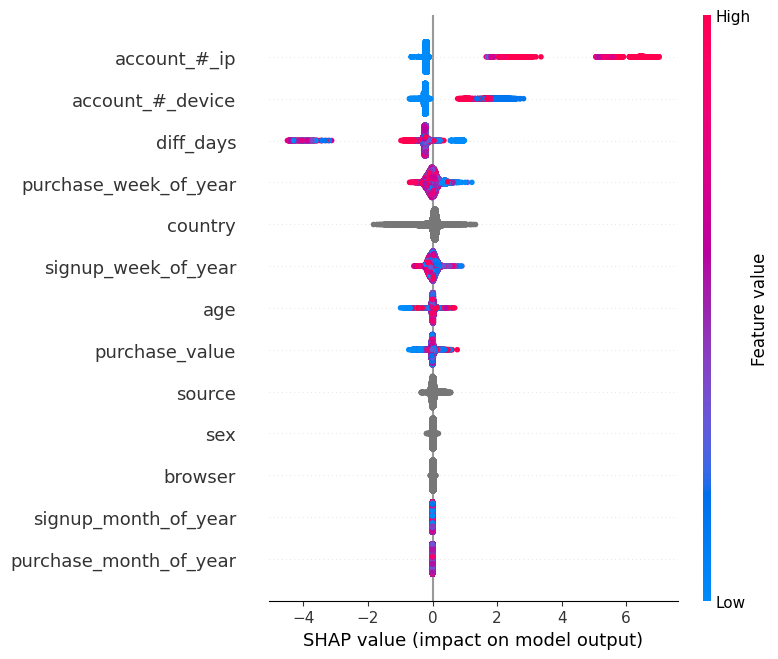

In [140]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
model=lgb.LGBMClassifier(verbose=-1) # use verbose to supress logs
model.fit(X_train,y_train,categorical_feature=categorical)
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
print(accuracy)
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=100)
cv_scores=cross_val_score(model,X,y,cv=cv,scoring="accuracy")
print(cv_scores)
# accuracy score is pretty high
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
importance=model.feature_importances_
feature_names=X.columns
importance_pd=pd.DataFrame({
    "features":feature_names,
    "importance": importance   
})
print(importance_pd.sort_values(by="importance", ascending=False))

import shap
explainer=shap.TreeExplainer(model)
shap_values=explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)


# Predict class probabilities with LGBM
the LGBM prediction likelihood of default with prab in %, when it pass threshold, it spit out 1 else 0.

In [141]:
proba = model.predict_proba(X_test)
# Extract probabilities for the positive class (e.g., default)
default_probability = proba[:, 1]  # Probability of class "1" (default)
print(default_probability)


[0.01779624 0.99873188 0.03148375 ... 0.034107   0.03727501 0.02891973]


# interpretation & conclusion from shap and feature importance 

The model works like a fraud investigator. It looks for patterns in the data and flags users who are more likely to engage in fraudulent behavior based on their characteristics and actions.
It doesn’t make random guesses—it identifies behaviors and attributes that, historically, are associated with fraud.


importance rank from high to low, right - higher likelihood of default, left - lower. 
Red: High feature value. Blue: Low feature value.

- high account# for same ip link with higher default %, account device # as well
- longer betwen signup and purchase day ---- lower default rate

# use case in product
Based on the model's predicted probability of fraud, segment users into risk levels:
Low Risk (Confidently Legitimate):
Users with low fraud probabilities (e.g., <10%).
Medium Risk (Uncertain Cases):
Users with moderate fraud probabilities (e.g., 10–50%).
High Risk (Confidently Fraudulent):
Users with high fraud probabilities (e.g., >50%).

Design User Experiences Based on Risk, For each risk level, tailor the user experience: additional verification process etc. 
